In [1]:
#IMPORTING LIBRARIES
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import zfit
import zfit.z.numpy as znp
import zfit_physics as zphysics 
from zfit import z  
import tensorflow as tf
import uproot
from matplotlib.gridspec import GridSpec

/Users/khrystina/new_env/lib/python3.11/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [10]:
#DOWLOADING DATASETS

files_simu = [
    '/Users/khrystina/Documents/first_attempt/KJpsi_data/simu/2016_MagDown.root',
    '/Users/khrystina/Documents/first_attempt/KJpsi_data/simu/2016_MagUp.root',
    '/Users/khrystina/Documents/first_attempt/KJpsi_data/simu/2017_MagDown.root',
    '/Users/khrystina/Documents/first_attempt/KJpsi_data/simu/2017_MagUp.root',
    '/Users/khrystina/Documents/first_attempt/KJpsi_data/simu/2018_MagDown.root',
    '/Users/khrystina/Documents/first_attempt/KJpsi_data/simu/2018_MagUp.root'
]

files_real_data = [
    '/Users/khrystina/Documents/first_attempt/KJpsi_data/real/2016_MagDown.root', 
    '/Users/khrystina/Documents/first_attempt/KJpsi_data/real/2016_MagUp.root',
    '/Users/khrystina/Documents/first_attempt/KJpsi_data/real/2017_MagDown.root', 
    '/Users/khrystina/Documents/first_attempt/KJpsi_data/real/2017_MagUp.root',
    '/Users/khrystina/Documents/first_attempt/KJpsi_data/real/2018_MagDown.root', 
    '/Users/khrystina/Documents/first_attempt/KJpsi_data/real/2018_MagUp.root'
]
simu_data = uproot.concatenate(files_simu, cut = 'Preselection==1', library='pd')
real_data = uproot.concatenate(files_real_data, cut = 'Preselection==1', library='pd')

In [15]:
#FUNCTION FOR PLOTTING
def plot_model_with_pulls(model, name, data, min, max, scale=1, nbins=50, plot_data=True):
    
    size_normal = len(data)
    lower, upper = data.data_range.limit1d
    x = np.linspace(lower, upper, num=1000)

    # Evaluate model PDF
    y = model.pdf(x) * size_normal / nbins * data.data_range.volume
    y *= scale
    fig = plt.figure(figsize=(8, 6))

    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05) 

    # Upper subplot: Model and Data with error bars
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(x, y, label="model", color="blue", linewidth=1)
    ax1.set_xlim(min, max)

    if plot_data:
        # Bin the data
        data_binned = data.to_binned(nbins)
        bin_centers = data_binned.axes[0].centers
        bin_widths = data_binned.axes[0].widths
        data_counts = data_binned.values()
        data_uncertainties = np.sqrt(data_counts)  # Poisson errors

        ax1.errorbar(
            bin_centers, data_counts, yerr=data_uncertainties, fmt='o', 
            color='orange', label="data", markersize=1, capsize=2
        )

    ax1.legend()
    ax1.set_ylabel("Counts")
    
    ax1.set_title(name)
    ax1.grid()

    # Lower subplot: Pulls visualization
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    if plot_data:
        # Compute pulls
        model_at_bins = model.pdf(bin_centers) * size_normal / nbins * data.data_range.volume
        pulls = (data_counts - model_at_bins) / data_uncertainties

        ax2.errorbar(
            bin_centers, pulls, yerr=1, fmt='o', 
            color='purple', label="pulls", markersize=1, capsize=2
        )
        ax2.axhline(0, color='black', linestyle='--', linewidth=1)
        ax2.set_ylim(-20, 20) 
        ax2.set_ylabel("Pulls")
        ax2.grid()
        ax2.legend()
    # ax1.set_yscale('log')
    ax2.set_xlabel("m(KJ/psi) [MeV]")
    plt.tight_layout()
    plt.show()

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1550/1533772692.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


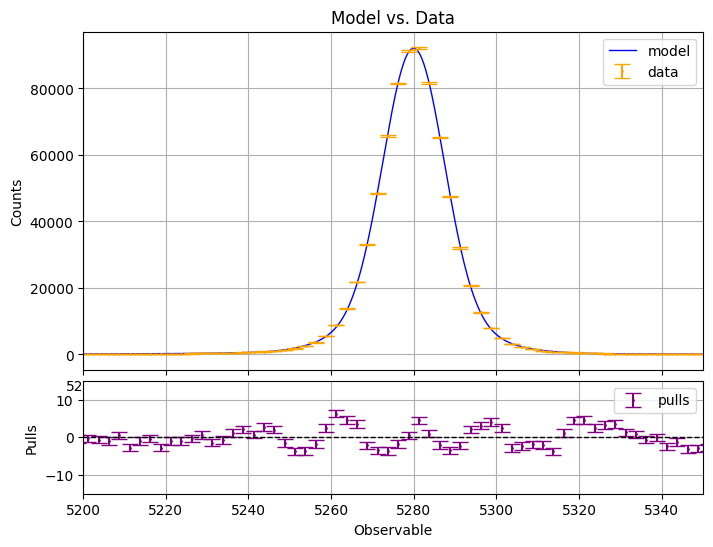

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[CB1_frac, Composed_autoparam_0, Gauss_frac]] data=[<zfit.Data: Data obs=('mass',) shape=(765191, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.0005 │       2839495.21 |  6256.834 │
╘═════════╧═════════════╧══════════════════╧════════╧══════════════════════════════╛

Parameters
name          value  (rounded)    at limit
----------  ------------------  ----------
CB1_frac            0.00975498       False
Gauss_frac             0.78168       False
mu_cb1                 5296.98       False
sigma1                 39.4313       False
alpha_1                   23.2       False
n_1                       

In [ ]:
#CHOSEN MODEL
#GAUSS AND TWO CRYSTALBALLS
real_mass = real_data['B_JpsiDTF_M']
real_mass_np = real_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(5150, 5400))
real_data_zfit = zfit.data.Data.from_numpy(array=real_mass_np, obs=mass_obs)

mu_g = zfit.Parameter('mu_g', 5279, 5279, 5290)
mu_cb1 = zfit.Parameter('mu_cb1', 5294, 5279, 6000)
mu_cb2 = zfit.Parameter('mu_cb2', 5279, 5279, 5290)
sigma = zfit.Parameter('sigma', 7.22, 0.1, 15)
sigma_1 = zfit.Parameter('sigma1', 38.24, 0.1, 70)
sigma_2 = zfit.Parameter('sigma2', 14.34, 0.1, 15)
alpha_1 = zfit.Parameter('alpha_1', 23.2, 0.1, 30)
n_1 = zfit.Parameter('n_1', 11.8, 0.1, 90)
alpha_2 = zfit.Parameter('alpha_2', 2.17, 1.0, 30)
n_2 = zfit.Parameter('n_2', 0.98, 0.1, 60)

Gauss = zfit.pdf.Gauss(obs=mass_obs, mu=mu_g, sigma=sigma)
CrystalBall_1 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb1, sigma=sigma_1, alpha=alpha_1, n=n_1)
CrystalBall_2 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb2, sigma=sigma_2, alpha=alpha_2, n=n_2)

Gauss_frac = zfit.Parameter('Gauss_frac', 0.76, 0, 1)
CB1_frac = zfit.Parameter('CB1_frac', 0.011, 0, 1)
supermodel = zfit.pdf.SumPDF([CrystalBall_1, Gauss, CrystalBall_2], [CB1_frac, Gauss_frac])

nll = zfit.loss.UnbinnedNLL(model=supermodel, data=real_data_zfit)
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)

plot_model_with_pulls(supermodel, real_data_zfit, 5200, 5350, nbins=100)
print(result)

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1550/1533772692.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


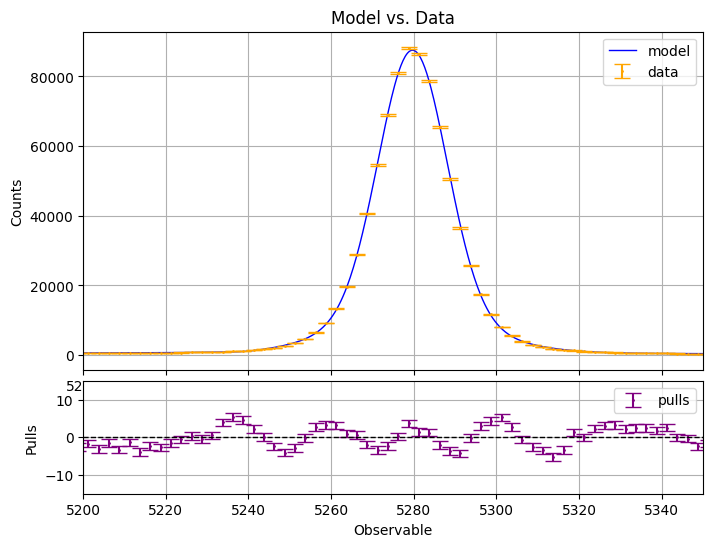

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[CB1_frac, Composed_autoparam_1, Gauss_frac]] data=[<zfit.Data: Data obs=('mass',) shape=(863533, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.00044 │       3464085.79 | -31718.91 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name           value  (rounded)    at limit
-----------  ------------------  ----------
CB1_frac              0.0259211       False
Gauss_frac             0.737643       False
mu_cb1_base             5331.53       False
shift_mu              -0.837716       False
sigma1_base             46.3067       False
scale_sigma   

In [11]:
#MODEL WITH COMPOSED PARAMETERS

# Load real data
real_mass = real_data['B_JpsiDTF_M']
real_mass_np = real_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(5150, 5400))
real_data_zfit = zfit.data.Data.from_numpy(array=real_mass_np, obs=mass_obs)

# Define shift and scale parameters
shift_mu = zfit.Parameter('shift_mu', 0, -10, 10)
scale_sigma = zfit.Parameter('scale_sigma', 1, 0.5, 1.5)

# Define original parameters
mu_g_base = zfit.Parameter('mu_g_base', 5279, 5279, 5290)
mu_cb1_base = zfit.Parameter('mu_cb1_base', 5294, 5279, 6000)
mu_cb2_base = zfit.Parameter('mu_cb2_base', 5279, 5279, 5290)
sigma_base = zfit.Parameter('sigma_base', 7.22, 0.1, 15)
sigma_1_base = zfit.Parameter('sigma1_base', 38.24, 0.1, 70)
sigma_2_base = zfit.Parameter('sigma2_base', 14.34, 0.1, 15)

alpha_1 = zfit.Parameter('alpha_1', 23.2, 0.1, 30)
n_1 = zfit.Parameter('n_1', 11.8, 0.1, 90)
alpha_2 = zfit.Parameter('alpha_2', 2.17, 1.0, 30)
n_2 = zfit.Parameter('n_2', 0.98, 0.1, 60)

# Define ComposedParameters
mu_g = zfit.ComposedParameter('mu_g', lambda mu, shift: mu + shift, params=[mu_g_base, shift_mu])
mu_cb1 = zfit.ComposedParameter('mu_cb1', lambda mu, shift: mu + shift, params=[mu_cb1_base, shift_mu])
mu_cb2 = zfit.ComposedParameter('mu_cb2', lambda mu, shift: mu + shift, params=[mu_cb2_base, shift_mu])

sigma = zfit.ComposedParameter('sigma', lambda sigma, scale: sigma * scale, params=[sigma_base, scale_sigma])
sigma_1 = zfit.ComposedParameter('sigma1', lambda sigma, scale: sigma * scale, params=[sigma_1_base, scale_sigma])
sigma_2 = zfit.ComposedParameter('sigma2', lambda sigma, scale: sigma * scale, params=[sigma_2_base, scale_sigma])

# Define PDFs
Gauss = zfit.pdf.Gauss(obs=mass_obs, mu=mu_g, sigma=sigma)
CrystalBall_1 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb1, sigma=sigma_1, alpha=alpha_1, n=n_1)
CrystalBall_2 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb2, sigma=sigma_2, alpha=alpha_2, n=n_2)

# Define fractions
Gauss_frac = zfit.Parameter('Gauss_frac', 0.76, 0, 1)
CB1_frac = zfit.Parameter('CB1_frac', 0.011, 0, 1)

# Define model
supermodel = zfit.pdf.SumPDF([CrystalBall_1, Gauss, CrystalBall_2], [CB1_frac, Gauss_frac])

# Define loss and minimization
nll = zfit.loss.UnbinnedNLL(model=supermodel, data=real_data_zfit)
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)

# Plot results
plot_model_with_pulls(supermodel, real_data_zfit, 5200, 5350, nbins=100)
print(result)


/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1550/1533772692.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


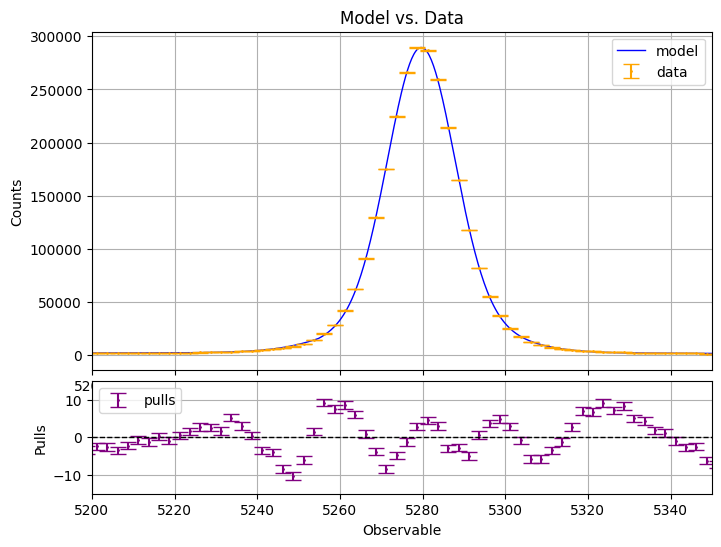

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_39, Composed_autoparam_40, Composed_autoparam_41]] data=[<zfit.Data: Data obs=('mass',) shape=(2797688, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.00049 │       11174275.07 | -1002309 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name           value  (rounded)    at limit
-----------  ------------------  ----------
frac_CB1              0.0330733       False
total_yield         2.79768e+06       False
frac_Gauss             0.250319       False
mu_cb1_base             5322.14       False
shift_mu                

In [28]:
#EXTENDED MODEL

# Load real data
real_mass = real_data['B_JpsiDTF_M']
real_mass_np = real_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(5150, 5400))
real_data_zfit = zfit.data.Data.from_numpy(array=real_mass_np, obs=mass_obs)

# Define shift and scale parameters
shift_mu = zfit.Parameter('shift_mu', -9.8, -12, 12)
scale_sigma = zfit.Parameter('scale_sigma', 1.7, 0.5, 1.9)

# Define original parameters
mu_g_base = zfit.Parameter('mu_g_base', 5279.7, 5279, 5290)
mu_cb1_base = zfit.Parameter('mu_cb1_base', 5295, 5279, 6000)
mu_cb2_base = zfit.Parameter('mu_cb2_base', 5279.4, 5279, 5290)
sigma_base = zfit.Parameter('sigma_base', 7.2, 0.1, 15)
sigma_1_base = zfit.Parameter('sigma1_base', 68.47, 0.1, 70)
sigma_2_base = zfit.Parameter('sigma2_base', 5.47, 0.1, 15)

alpha_1 = zfit.Parameter('alpha_1', 23.2, 0.1, 30)
n_1 = zfit.Parameter('n_1', 11.8, 0.1, 30)
alpha_2 = zfit.Parameter('alpha_2', 2.38, 1.0, 30)
n_2 = zfit.Parameter('n_2', 0.9, 0.01, 30)

# Define ComposedParameters
mu_g = zfit.ComposedParameter('mu_g', lambda mu, shift: mu + shift, params=[mu_g_base, shift_mu])
mu_cb1 = zfit.ComposedParameter('mu_cb1', lambda mu, shift: mu + shift, params=[mu_cb1_base, shift_mu])
mu_cb2 = zfit.ComposedParameter('mu_cb2', lambda mu, shift: mu + shift, params=[mu_cb2_base, shift_mu])

sigma = zfit.ComposedParameter('sigma', lambda sigma, scale: sigma * scale, params=[sigma_base, scale_sigma])
sigma_1 = zfit.ComposedParameter('sigma1', lambda sigma, scale: sigma * scale, params=[sigma_1_base, scale_sigma])
sigma_2 = zfit.ComposedParameter('sigma2', lambda sigma, scale: sigma * scale, params=[sigma_2_base, scale_sigma])

# Define PDFs
Gauss = zfit.pdf.Gauss(obs=mass_obs, mu=mu_g, sigma=sigma)
CrystalBall_1 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb1, sigma=sigma_1, alpha=alpha_1, n=n_1)
CrystalBall_2 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb2, sigma=sigma_2, alpha=alpha_2, n=n_2)

# Define yields (expected number of events for each component)
total_yield = zfit.Parameter('total_yield', len(real_mass_np), 0, 2 * len(real_mass_np))
frac_Gauss = zfit.Parameter('frac_Gauss', 0.76, 0, 1)
frac_CB1 = zfit.Parameter('frac_CB1', 0.024, 0, 1)

yield_Gauss = zfit.ComposedParameter('yield_Gauss', lambda frac, total: frac * total, params=[frac_Gauss, total_yield])
yield_CB1 = zfit.ComposedParameter('yield_CB1', lambda frac, total: frac * total, params=[frac_CB1, total_yield])
yield_CB2 = zfit.ComposedParameter('yield_CB2', lambda y1, y2, total: total - y1 - y2, params=[yield_Gauss, yield_CB1, total_yield])

# Convert PDFs into Extended PDFs
Gauss_ext = Gauss.create_extended(yield_Gauss)
CrystalBall_1_ext = CrystalBall_1.create_extended(yield_CB1)
CrystalBall_2_ext = CrystalBall_2.create_extended(yield_CB2)

# Define the final model as a sum of the extended PDFs
supermodel = zfit.pdf.SumPDF([CrystalBall_1_ext, Gauss_ext, CrystalBall_2_ext])

# Define loss (Extended Unbinned Likelihood)
nll = zfit.loss.ExtendedUnbinnedNLL(model=supermodel, data=real_data_zfit)

# Minimize the loss function
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)

# Plot results
plot_model_with_pulls(supermodel, real_data_zfit, 5200, 5350, nbins=100)
print(result)


In [29]:
# Get best-fit values for yields
yield_Gauss_val = yield_Gauss.value().numpy()
yield_CB1_val = yield_CB1.value().numpy()
yield_CB2_val = yield_CB2.value().numpy()
total_yield_val = total_yield.value().numpy()

# Print number of events in each component
print(f"Number of events (Gaussian): {yield_Gauss_val:.2f}")
print(f"Number of events (CrystalBall 1): {yield_CB1_val:.2f}")
print(f"Number of events (CrystalBall 2): {yield_CB2_val:.2f}")
print(f"Total number of events: {total_yield_val:.2f}")


Number of events (Gaussian): 700315.14
Number of events (CrystalBall 1): 92528.68
Number of events (CrystalBall 2): 2004841.24
Total number of events: 2797685.07


In [30]:


result.hesse(method="approx")


{<zfit.Parameter 'frac_CB1' floating=True value=0.03307>: {'error': np.float64(0.00047883743060058966),
  'cl': 0.68268949},
 <zfit.Parameter 'total_yield' floating=True value=2.798e+06>: {'error': np.float64(1679.7987081799513),
  'cl': 0.68268949},
 <zfit.Parameter 'frac_Gauss' floating=True value=0.2503>: {'error': np.float64(0.002969916352170487),
  'cl': 0.68268949},
 <zfit.Parameter 'mu_cb1_base' floating=True value=5322>: {'error': np.float64(0.7944831770277869),
  'cl': 0.68268949},
 <zfit.Parameter 'shift_mu' floating=True value=-5.214>: {'error': np.float64(0.010282537783600176),
  'cl': 0.68268949},
 <zfit.Parameter 'sigma1_base' floating=True value=29.09>: {'error': np.float64(0.26839170580123795),
  'cl': 0.68268949},
 <zfit.Parameter 'scale_sigma' floating=True value=1.895>: {'error': np.float64(0.00037994388279815385),
  'cl': 0.68268949},
 <zfit.Parameter 'alpha_1' floating=True value=23.2>: {'error': np.float64(12.533155971768203),
  'cl': 0.68268949},
 <zfit.Parameter

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1550/1533772692.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


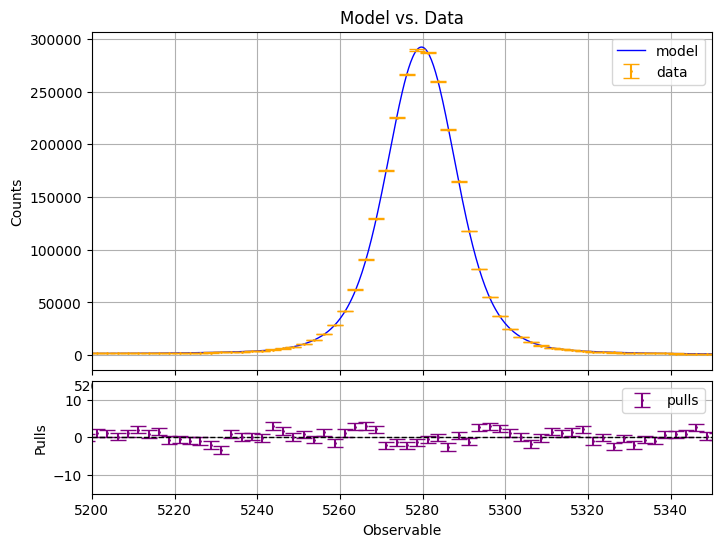

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_43, Composed_autoparam_44, Composed_autoparam_45, Composed_autoparam_46]] data=[<zfit.Data: Data obs=('mass',) shape=(2797688, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.0011 │      11173173.89 | -952797.2 │
╘═════════╧═════════════╧══════════════════╧════════╧══════════════════════════════╛

Parameters
name           value  (rounded)    at limit
-----------  ------------------  ----------
frac_CB1              0.0673582       False
total_yield         2.79771e+06       False
frac_Gauss             0.390804       False
frac_bkg              0.0468915       False
mu_cb1

In [31]:
# EXTENDED MODEL WITH BACKGROUND

# Load real data
real_mass = real_data['B_JpsiDTF_M']
real_mass_np = real_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(5150, 5400))
real_data_zfit = zfit.data.Data.from_numpy(array=real_mass_np, obs=mass_obs)

# Define shift and scale parameters
shift_mu = zfit.Parameter('shift_mu', -9.8, -12, 12)
scale_sigma = zfit.Parameter('scale_sigma', 1.7, 0.5, 1.9)

# Define original parameters
mu_g_base = zfit.Parameter('mu_g_base', 5279.7, 5279, 5290)
mu_cb1_base = zfit.Parameter('mu_cb1_base', 5295, 5279, 6000)
mu_cb2_base = zfit.Parameter('mu_cb2_base', 5279.4, 5279, 5290)
sigma_base = zfit.Parameter('sigma_base', 7.2, 0.1, 15)
sigma_1_base = zfit.Parameter('sigma1_base', 68.47, 0.1, 70)
sigma_2_base = zfit.Parameter('sigma2_base', 5.47, 0.1, 15)

alpha_1 = zfit.Parameter('alpha_1', 23.2, 0.1, 30)
n_1 = zfit.Parameter('n_1', 11.8, 0.1, 30)
alpha_2 = zfit.Parameter('alpha_2', 2.38, 1.0, 30)
n_2 = zfit.Parameter('n_2', 0.9, 0.01, 30)

# Define ComposedParameters
mu_g = zfit.ComposedParameter('mu_g', lambda mu, shift: mu + shift, params=[mu_g_base, shift_mu])
mu_cb1 = zfit.ComposedParameter('mu_cb1', lambda mu, shift: mu + shift, params=[mu_cb1_base, shift_mu])
mu_cb2 = zfit.ComposedParameter('mu_cb2', lambda mu, shift: mu + shift, params=[mu_cb2_base, shift_mu])

sigma = zfit.ComposedParameter('sigma', lambda sigma, scale: sigma * scale, params=[sigma_base, scale_sigma])
sigma_1 = zfit.ComposedParameter('sigma1', lambda sigma, scale: sigma * scale, params=[sigma_1_base, scale_sigma])
sigma_2 = zfit.ComposedParameter('sigma2', lambda sigma, scale: sigma * scale, params=[sigma_2_base, scale_sigma])

# Define PDFs
Gauss = zfit.pdf.Gauss(obs=mass_obs, mu=mu_g, sigma=sigma)
CrystalBall_1 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb1, sigma=sigma_1, alpha=alpha_1, n=n_1)
CrystalBall_2 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb2, sigma=sigma_2, alpha=alpha_2, n=n_2)

# Define Background PDF (Exponential)
lambda_bkg = zfit.Parameter('lambda_bkg', -0.002, -0.01, 0.0)  # Negative for a falling exp
bkg_pdf = zfit.pdf.Exponential(obs=mass_obs, lambda_=lambda_bkg)

# Define yields (expected number of events for each component)
total_yield = zfit.Parameter('total_yield', len(real_mass_np), 0, 2 * len(real_mass_np))
frac_Gauss = zfit.Parameter('frac_Gauss', 0.76, 0, 1)
frac_CB1 = zfit.Parameter('frac_CB1', 0.024, 0, 1)
frac_bkg = zfit.Parameter('frac_bkg', 0.1, 0, 1)

yield_Gauss = zfit.ComposedParameter('yield_Gauss', lambda frac, total: frac * total, params=[frac_Gauss, total_yield])
yield_CB1 = zfit.ComposedParameter('yield_CB1', lambda frac, total: frac * total, params=[frac_CB1, total_yield])
yield_bkg = zfit.ComposedParameter('yield_bkg', lambda frac, total: frac * total, params=[frac_bkg, total_yield])
yield_CB2 = zfit.ComposedParameter('yield_CB2', lambda y1, y2, y3, total: total - y1 - y2 - y3, params=[yield_Gauss, yield_CB1, yield_bkg, total_yield])

# Convert PDFs into Extended PDFs
Gauss_ext = Gauss.create_extended(yield_Gauss)
CrystalBall_1_ext = CrystalBall_1.create_extended(yield_CB1)
CrystalBall_2_ext = CrystalBall_2.create_extended(yield_CB2)
bkg_pdf_ext = bkg_pdf.create_extended(yield_bkg)

# Define the final model as a sum of the extended PDFs
supermodel = zfit.pdf.SumPDF([CrystalBall_1_ext, Gauss_ext, CrystalBall_2_ext, bkg_pdf_ext])

# Define loss (Extended Unbinned Likelihood)
nll = zfit.loss.ExtendedUnbinnedNLL(model=supermodel, data=real_data_zfit)

# Minimize the loss function
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)

# Plot results
plot_model_with_pulls(supermodel, real_data_zfit, 5200, 5350, nbins=100)
print(result)


/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1550/2917409886.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


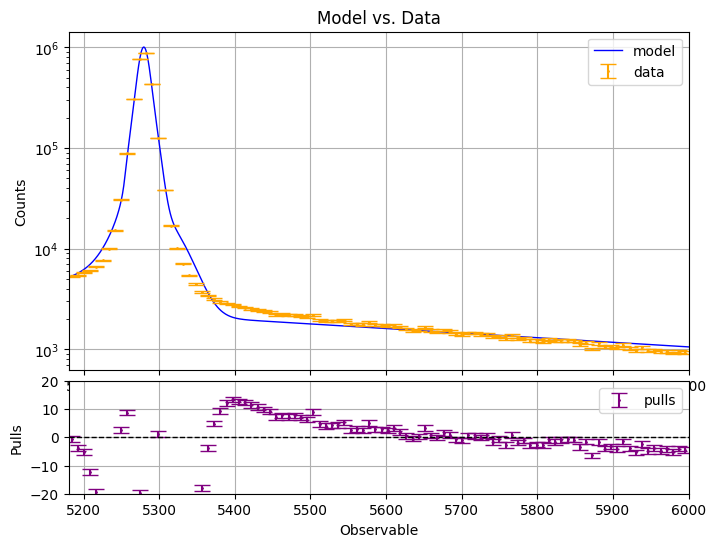

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_90, Composed_autoparam_91]] data=[<zfit.Data: Data obs=('mass',) shape=(2888926, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 3.6e-05 │       12178656.21 | -2850607 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name            value  (rounded)    at limit
------------  ------------------  ----------
signal_yield         2.72103e+06       False
bck_yield                 167887       False
shift_mu                0.544048       False
scale_sigma             0.818914       False
lambda_bkg           -0.00104942       Fa

In [58]:
# EXTENDED MODEL WITH BACKGROUND FIXED

# Load real data
real_mass = real_data['B_JpsiDTF_M']
real_mass_np = real_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(5180, 6000))
real_data_zfit = zfit.data.Data.from_numpy(array=real_mass_np, obs=mass_obs)

# Define shift and scale parameters
shift_mu = zfit.Parameter('shift_mu', -7.3, -12, 12)
scale_sigma = zfit.Parameter('scale_sigma', 1.47, 0.5, 1.9)

# Define original parameters
mu_g_base = zfit.Parameter('mu_g_base', 5279, 5279, 5290, floating=False)
mu_cb1_base = zfit.Parameter('mu_cb1_base', 5294, 5279, 6000, floating=False)
mu_cb2_base = zfit.Parameter('mu_cb2_base', 5279., 5279, 5290, floating=False)
sigma_base = zfit.Parameter('sigma_base', 7.22, 0.1, 15, floating=False)
sigma_1_base = zfit.Parameter('sigma1_base', 38.24, 0.1, 50, floating=False)
sigma_2_base = zfit.Parameter('sigma2_base', 14.34, 0.1, 15, floating=False)

alpha_1 = zfit.Parameter('alpha_1', 23.2, 0.1, 30, floating=False)
n_1 = zfit.Parameter('n_1', 11.8, 0.1, 30, floating=False)
alpha_2 = zfit.Parameter('alpha_2', 2.17, 1.0, 30, floating=False)
n_2 = zfit.Parameter('n_2', 0.98, 0.01, 30, floating=False)

# Define ComposedParameters
mu_g = zfit.ComposedParameter('mu_g', lambda mu, shift: mu + shift, params=[mu_g_base, shift_mu])
mu_cb1 = zfit.ComposedParameter('mu_cb1', lambda mu, shift: mu + shift, params=[mu_cb1_base, shift_mu])
mu_cb2 = zfit.ComposedParameter('mu_cb2', lambda mu, shift: mu + shift, params=[mu_cb2_base, shift_mu])

sigma = zfit.ComposedParameter('sigma', lambda sigma, scale: sigma * scale, params=[sigma_base, scale_sigma])
sigma_1 = zfit.ComposedParameter('sigma1', lambda sigma, scale: sigma * scale, params=[sigma_1_base, scale_sigma])
sigma_2 = zfit.ComposedParameter('sigma2', lambda sigma, scale: sigma * scale, params=[sigma_2_base, scale_sigma])

# Define PDFs
Gauss = zfit.pdf.Gauss(obs=mass_obs, mu=mu_g, sigma=sigma)
CrystalBall_1 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb1, sigma=sigma_1, alpha=alpha_1, n=n_1)
CrystalBall_2 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb2, sigma=sigma_2, alpha=alpha_2, n=n_2)

# Define Background PDF (Exponential)
lambda_bkg = zfit.Parameter('lambda_bkg', -0.0032, -0.01, 0.0)  # Negative for a falling exp
bkg_pdf = zfit.pdf.Exponential(obs=mass_obs, lambda_=lambda_bkg)


# Define yields (expected number of events for each component)
# total_yield = zfit.Parameter('total_yield', len(real_mass_np), 0, 2 * len(real_mass_np))
frac_Gauss = zfit.Parameter('frac_Gauss', 0.39, 0, 1, floating=False)
frac_CB1 = zfit.Parameter('frac_CB1', 0.067, 0, 1, floating=False)
frac_bkg = zfit.Parameter('frac_bkg', 0.047, 0, 1)

# yield_Gauss = zfit.ComposedParameter('yield_Gauss', lambda frac, total: frac * total, params=[frac_Gauss, total_yield])
# yield_CB1 = zfit.ComposedParameter('yield_CB1', lambda frac, total: frac * total, params=[frac_CB1, total_yield])
# yield_bkg = zfit.ComposedParameter('yield_bkg', lambda frac, total: frac * total, params=[frac_bkg, total_yield])
# yield_CB2 = zfit.ComposedParameter('yield_CB2', lambda y1, y2, y3, total: total - y1 - y2 - y3, params=[yield_Gauss, yield_CB1, yield_bkg, total_yield])

signal_yield = zfit.Parameter('signal_yield', len(real_mass_np), 0, len(real_mass_np))
bck_yield = zfit.Parameter('bck_yield', len(real_mass_np), 0, len(real_mass_np))
#MODEL FOR SIGNAL:
signal_pdf = zfit.pdf.SumPDF([CrystalBall_1, Gauss, CrystalBall_2], [frac_CB1, frac_Gauss])
signal_extended = signal_pdf.create_extended(signal_yield)
#MODEL FOR BACKGROUND:
bkg_ext = bkg_pdf.create_extended(bck_yield)

# Define the final model as a sum of the extended PDFs
supermodel = zfit.pdf.SumPDF([signal_extended, bkg_ext])

# Define loss (Extended Unbinned Likelihood)
nll = zfit.loss.ExtendedUnbinnedNLL(model=supermodel, data=real_data_zfit)

# Minimize the loss function
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)

# Plot results
plot_model_with_pulls(supermodel, real_data_zfit, 5180, 6000, nbins=100, )
print(result)


/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1550/2917409886.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


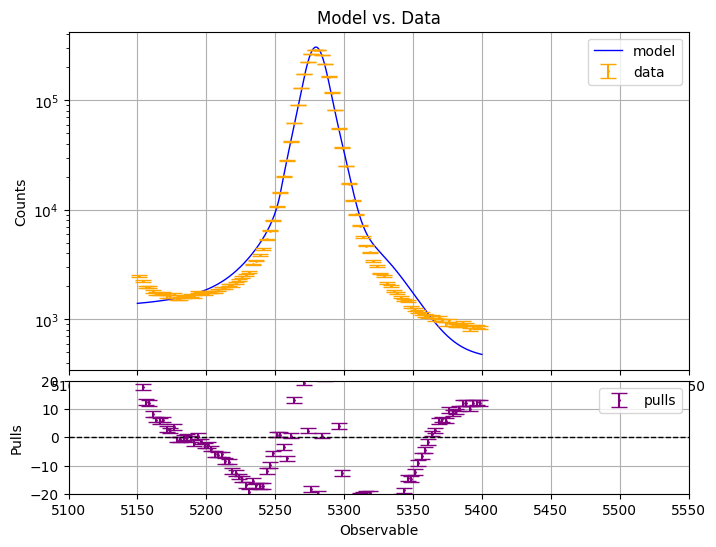

{<zfit.Parameter 'signal_yield' floating=True value=2.736e+06>: {'error': np.float64(1692.986424082593), 'cl': 0.68268949}, <zfit.Parameter 'bck_yield' floating=True value=6.145e+04>: {'error': np.float64(437.8852770927136), 'cl': 0.68268949}, <zfit.Parameter 'shift_mu' floating=True value=0.5474>: {'error': np.float64(0.006098988533576149), 'cl': 0.68268949}, <zfit.Parameter 'scale_sigma' floating=True value=0.8222>: {'error': np.float64(0.0005360501657576574), 'cl': 0.68268949}, <zfit.Parameter 'lambda_bkg' floating=True value=-0.002256>: {'error': np.float64(7.995184486301998e-05), 'cl': 0.68268949}}
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_85, Composed_autoparam_86]] data=[<zfit.Data: Data obs=('mass',) shape=(2797688, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │  

In [57]:
plot_model_with_pulls(supermodel, real_data_zfit, 5100, 5550, nbins=100)
print(result.hesse(method="approx"))
print(result)

In [40]:
hesse_result = result.hesse(method="approx")
for param, values in hesse_result.items():
    print(f"{param}:")
    for key, val in values.items():
        print(f"  {key}: {val}")


<zfit.Parameter 'frac_CB1' floating=True value=0.0677>:
  error: 0.0018551712360643038
  cl: 0.68268949
<zfit.Parameter 'total_yield' floating=True value=2.798e+06>:
  error: 1675.5654232597221
  cl: 0.68268949
<zfit.Parameter 'frac_Gauss' floating=True value=0.3918>:
  error: 0.01113050733476292
  cl: 0.68268949
<zfit.Parameter 'frac_bkg' floating=True value=0.04695>:
  error: 0.0002382108483949352
  cl: 0.68268949
<zfit.Parameter 'mu_cb1_base' floating=True value=5287>:
  error: 0.1802893174049401
  cl: 0.68268949
<zfit.Parameter 'shift_mu' floating=True value=-6.978>:
  error: 0.006019967114281022
  cl: 0.68268949
<zfit.Parameter 'sigma1_base' floating=True value=18.34>:
  error: 0.1733435371610724
  cl: 0.68268949
<zfit.Parameter 'scale_sigma' floating=True value=1.471>:
  error: 0.004733167707771288
  cl: 0.68268949
<zfit.Parameter 'alpha_1' floating=True value=23.2>:
  error: 12.533155971768203
  cl: 0.68268949
<zfit.Parameter 'n_1' floating=True value=11.8>:
  error: 14.59246374

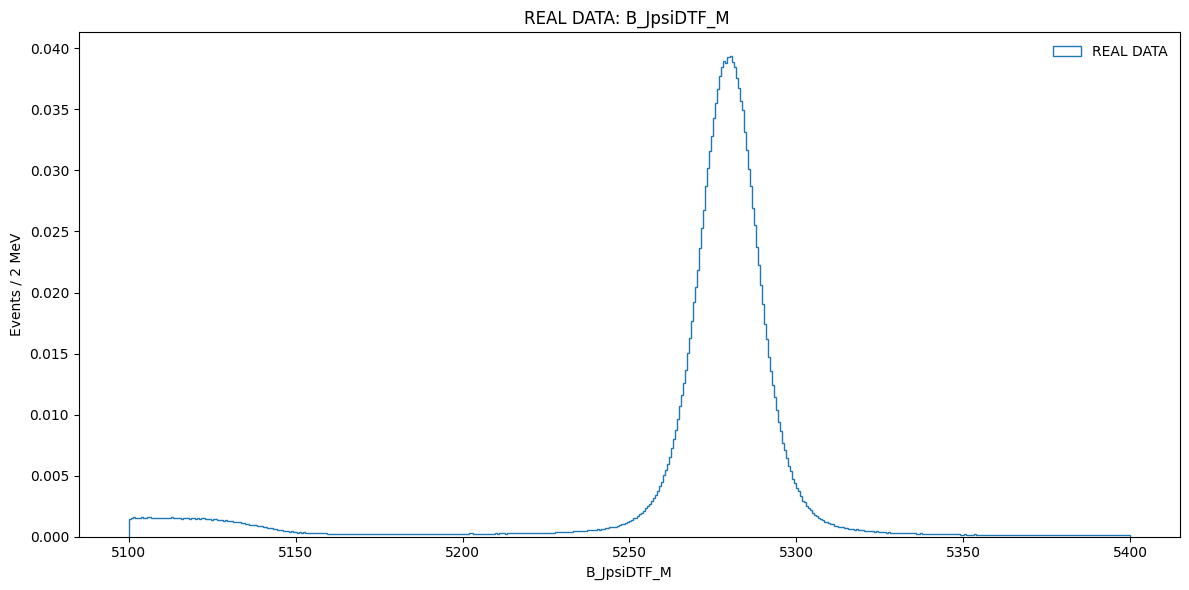

In [45]:
fig, axes = plt.subplots(figsize=(12, 6))
axes.hist(real_data['B_JpsiDTF_M'], bins=500, histtype='step',density = True, range=(5100,5400), label='REAL DATA')
axes.set_xlabel('B_JpsiDTF_M')
axes.set_ylabel('Events / 2 MeV')
axes.set_title('REAL DATA: B_JpsiDTF_M ')
axes.legend(frameon=False)

plt.tight_layout()

plt.show()

In [94]:
# Parameters for the Voigt profile
real_mass = real_data['B_JpsiDTF_M']
real_mass_np = real_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(5180, 6000))
real_data_zfit = zfit.data.Data.from_numpy(array=real_mass_np, obs=mass_obs)

shift_mu = zfit.Parameter('shift_mu', 0.5, -12, 12)
scale_sigma = zfit.Parameter('scale_sigma', 0.8, 0.5, 1.9)

mu_voigt_base = zfit.Parameter('mu_voigt', 5279, 5279, 5290, floating=False)
sigma_voigt_base = zfit.Parameter('sigma_voigt', 7.44, 0.1, 15, floating=False)
gamma_voigt = zfit.Parameter('gamma_voigt', 1.32, 0, 50, floating=False)

mu_voigt = zfit.ComposedParameter('mu_g', lambda mu, shift: mu + shift, params=[mu_voigt_base, shift_mu])
sigma_voigt = zfit.ComposedParameter('sigma', lambda sigma, scale: sigma * scale, params=[sigma_voigt_base, scale_sigma])

# Define the PDF (Voigt profile)
Voigt = zfit.pdf.Voigt(obs=mass_obs, m=mu_voigt, sigma=sigma_voigt, gamma=gamma_voigt)

lambda_bkg = zfit.Parameter('lambda_bkg', -0.001, -0.01, 0.0)  # Negative for a falling exp
bkg_pdf = zfit.pdf.Exponential(obs=mass_obs, lambda_=lambda_bkg)

frac_voigt = zfit.Parameter('frac_voigt', 0.067, 0, 1, floating=False)
frac_bkg = zfit.Parameter('frac_bkg', 0.047, 0, 1)

signal_yield = zfit.Parameter('signal_yield', 0.8*len(real_mass_np), 0, len(real_mass_np))
bck_yield = zfit.Parameter('bck_yield', 0.2*len(real_mass_np), 0, len(real_mass_np))

signal_extended = Voigt.create_extended(signal_yield)
bkg_ext = bkg_pdf.create_extended(bck_yield)
supermodel = zfit.pdf.SumPDF([signal_extended, bkg_ext])

nll = zfit.loss.ExtendedUnbinnedNLL(model=supermodel, data=real_data_zfit)

# Minimizer
minimizer_minuit = zfit.minimize.Minuit()
result_voigt = minimizer_minuit.minimize(loss=nll)

# Plot result
plot_model_with_pulls(supermodel, real_data_zfit, 5180, 6000, nbins=100)

print(result_voigt)


TypeError: plot_model_with_pulls() missing 1 required positional argument: 'max'

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1550/2028700416.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


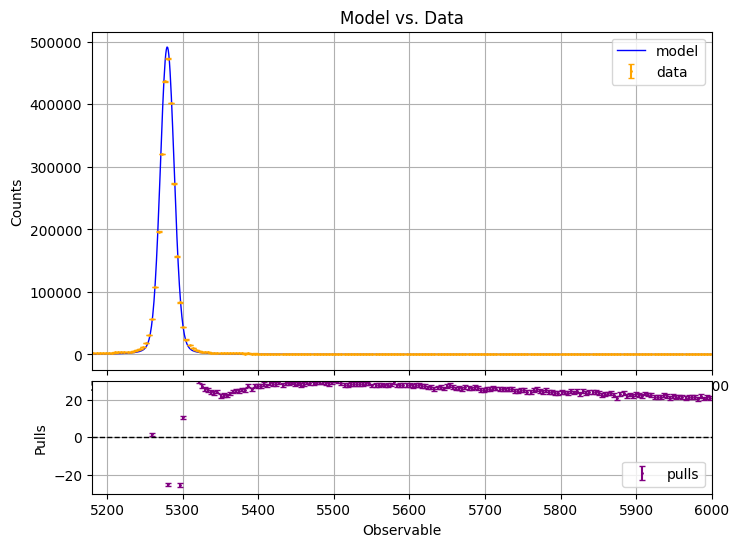

In [70]:
plot_model_with_pulls(Voigt, real_data_zfit, 5180, 6000, nbins=200)

In [9]:
print(real_data.columns)


Index(['index', 'Bc_ETA', 'Bc_MINIP', 'Bc_MINIPCHI2', 'Bc_PHI',
       'Bc_ENDVERTEX_X', 'Bc_ENDVERTEX_Y', 'Bc_ENDVERTEX_Z',
       'Bc_ENDVERTEX_XERR', 'Bc_ENDVERTEX_YERR',
       ...
       'nTTClusters', 'nOTClusters', 'nSPDHits', 'nMuonCoordsS0',
       'nMuonCoordsS1', 'nMuonCoordsS2', 'nMuonCoordsS3', 'nMuonCoordsS4',
       'nMuonTracks', 'q2'],
      dtype='object', length=1075)


/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1665/40758291.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


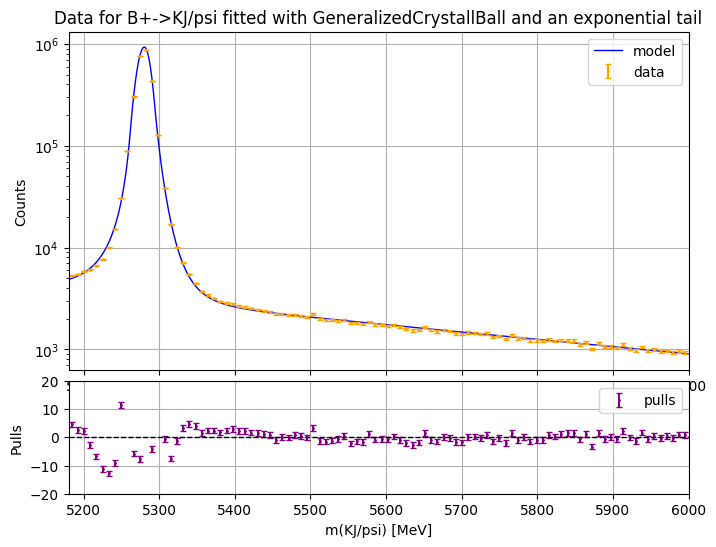

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_4, Composed_autoparam_5]] data=[<zfit.Data: Data obs=('mass',) shape=(2888926, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 5.3e-06 │      12169767.63 | -154794.6 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name            value  (rounded)    at limit
------------  ------------------  ----------
signal_yield         2.69813e+06       False
bck_yield                 190798       False
shift_mu                0.900611       False
scale_sigma               1.1316       False
lambda_bkg           -0.00164818       Fals

In [14]:
#WITH GENERILISED CB
real_mass = real_data['B_JpsiDTF_M']
real_mass_np = real_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(5180, 6000))
real_data_zfit = zfit.data.Data.from_numpy(array=real_mass_np, obs=mass_obs)

shift_mu = zfit.Parameter('shift_mu', 0.9, -12, 12)
scale_sigma = zfit.Parameter('scale_sigma', 1.1, 0.5, 1.9)

mu_gcb_base = zfit.Parameter('mu_gcb', 5279.4, 5279, 5290, floating=False)
sigma_gcb_l_base = zfit.Parameter('sigma_gcb_l', 8.4, 0.1, 15, floating=False)
sigma_gcb_r_base = zfit.Parameter('sigma_gcb_r', 7.4, 0.1, 15, floating=False)
alpha_gcb_l = zfit.Parameter('alpha_gcb_l', 2., 0.1, 30, floating=False)
n_gcb_l = zfit.Parameter('n_gcb_l', 2., 0.1, 20, floating=False)
alpha_gcb_r = zfit.Parameter('alpha_gcb_r', 1.6, 0.1, 30, floating=False)
n_gcb_r = zfit.Parameter('n_gcb_r', 4., 0.1, 20, floating=False)


mu_gcb = zfit.ComposedParameter('mu_g', lambda mu, shift: mu + shift, params=[mu_gcb_base, shift_mu])
sigma_gcb_l = zfit.ComposedParameter('sigma_l', lambda sigma, scale: sigma * scale, params=[sigma_gcb_l_base, scale_sigma])
sigma_gcb_r = zfit.ComposedParameter('sigma_r', lambda sigma, scale: sigma * scale, params=[sigma_gcb_r_base, scale_sigma])

# Define the PDF (gcb profile)
gcb = zfit.pdf.GeneralizedCB(obs=mass_obs, mu=mu_gcb, sigmal=sigma_gcb_l, sigmar=sigma_gcb_r, alphal=alpha_gcb_l, nl=n_gcb_l, alphar=alpha_gcb_r, nr=n_gcb_r)

lambda_bkg = zfit.Parameter('lambda_bkg', -0.0016, -0.01, 0.0)  # Negative for a falling exp
bkg_pdf = zfit.pdf.Exponential(obs=mass_obs, lambda_=lambda_bkg)

frac_gcb = zfit.Parameter('frac_gcb', 0.7, 0, 1, floating=False)
frac_bkg = zfit.Parameter('frac_bkg', 0.3, 0, 1)

signal_yield = zfit.Parameter('signal_yield', 0.8*len(real_mass_np), 0, len(real_mass_np))
bck_yield = zfit.Parameter('bck_yield', 0.2*len(real_mass_np), 0, len(real_mass_np))

signal_extended = gcb.create_extended(signal_yield)
bkg_ext = bkg_pdf.create_extended(bck_yield)
supermodel = zfit.pdf.SumPDF([signal_extended, bkg_ext])

nll = zfit.loss.ExtendedUnbinnedNLL(model=supermodel, data=real_data_zfit)

# Minimizer
minimizer_minuit = zfit.minimize.Minuit()
result_gcb = minimizer_minuit.minimize(loss=nll)

# Plot result
plot_model_with_pulls(supermodel, "Data for B+->KJ/psi fitted with GeneralizedCrystallBall and an exponential tail", real_data_zfit, 5180, 6000, nbins=100)

print(result_gcb)

In [5]:
print(f"Number of events signal: {signal_yield:.2f}")
print(f"Number of events background: {bck_yield:.2f}")

TypeError: unsupported format string passed to Parameter.__format__

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1550/4052584745.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


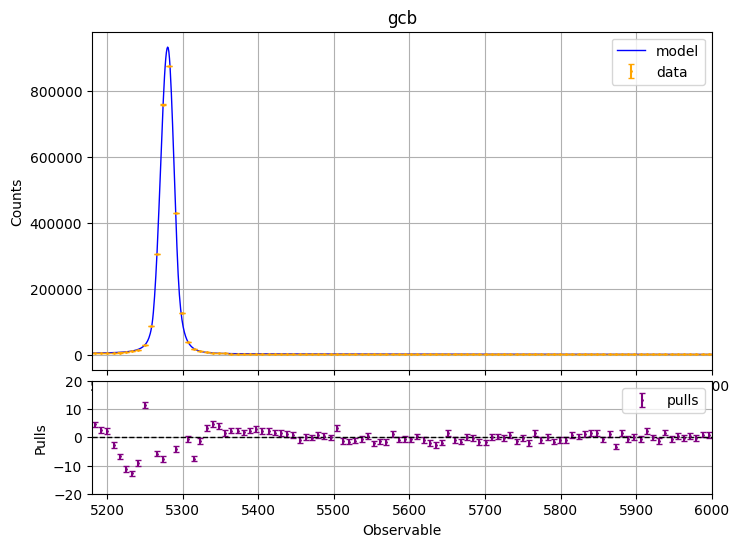

In [105]:
plot_model_with_pulls(supermodel, "gcb", real_data_zfit, 5180, 6000, nbins=100)

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1665/1296627556.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


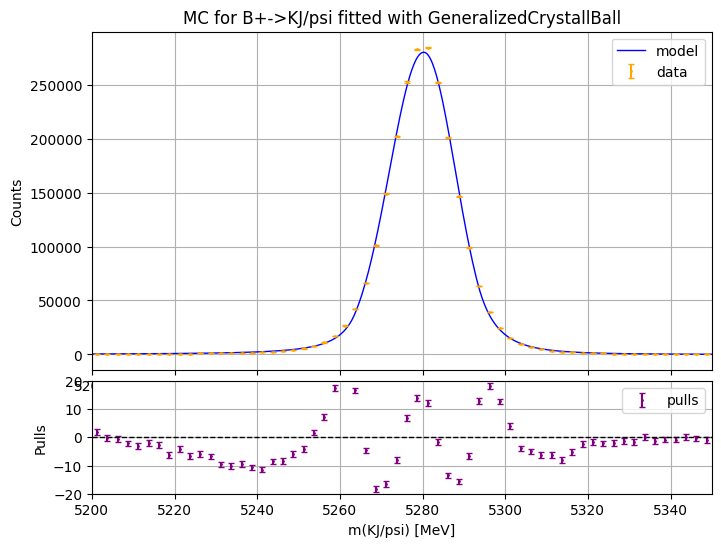

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.physics.GeneralizedCB'>  params=[alpha_gcb_l, alpha_gcb_r, mu_gcb, n_gcb_l, n_gcb_r, sigma_gcb_l, sigma_gcb_r]] data=[<zfit.Data: Data obs=('mass',) shape=(2360305, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 5.1e-08 │        8758045.30 | -8804.15 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name           value  (rounded)    at limit
-----------  ------------------  ----------
mu_gcb                  5280.28       False
sigma_gcb_l             8.31783       False
alpha_gcb_l             1.99855       False
n_gcb_l                 2.17058       False
sigma_gcb_r     

In [16]:
#GENERALIZEDCRYSTALLBALL
# Parameters
simu_mass = simu_data['B_JpsiDTF_M']
simu_mass_np = simu_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(5150, 5400))
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)
mu_gcb = zfit.Parameter('mu_gcb', 5279.4, 5279, 5290)
sigma_gcb_l = zfit.Parameter('sigma_gcb_l', 8.4, 0.1, 15)
sigma_gcb_r = zfit.Parameter('sigma_gcb_r', 7.4, 0.1, 15)
alpha_gcb_l = zfit.Parameter('alpha_gcb_l', 2., 0.1, 30)
n_gcb_l = zfit.Parameter('n_gcb_l', 2., 0.1, 20)
alpha_gcb_r = zfit.Parameter('alpha_gcb_r', 1.6, 0.1, 30)
n_gcb_r = zfit.Parameter('n_gcb_r', 4., 0.1, 20)
# Define the PDF (gcb profile)
gcb = zfit.pdf.GeneralizedCB(obs=mass_obs, mu=mu_gcb, sigmal=sigma_gcb_l, sigmar=sigma_gcb_r, alphal=alpha_gcb_l, nl=n_gcb_l, alphar=alpha_gcb_r, nr=n_gcb_r)

# Loss function (Unbinned NLL)
nll_gcb = zfit.loss.UnbinnedNLL(model=gcb, data=simu_data_zfit)

# Minimizer
minimizer_minuit = zfit.minimize.Minuit()
result_gcb = minimizer_minuit.minimize(loss=nll_gcb)

# Plot result
plot_model_with_pulls(gcb, "MC for B+->KJ/psi fitted with GeneralizedCrystallBall", simu_data_zfit, 5200, 5350, nbins=100)
print(result_gcb)

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1550/1521555536.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


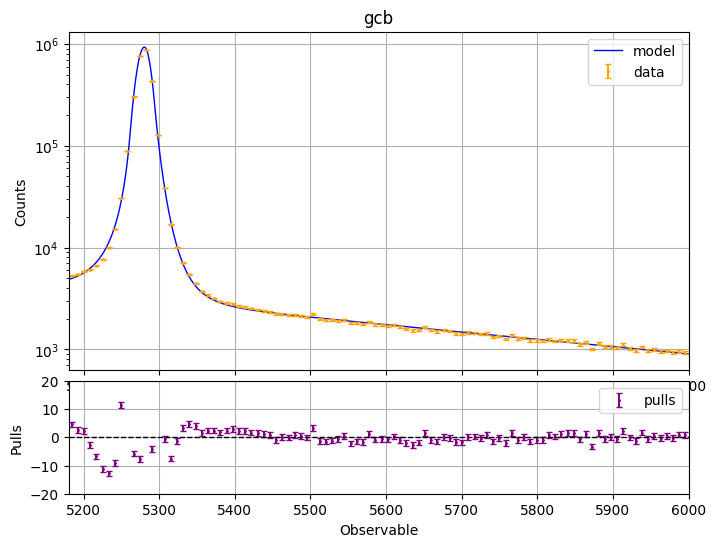

In [107]:
plot_model_with_pulls(supermodel, "gcb", real_data_zfit, 5180, 6000, nbins=100)

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1550/664640697.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


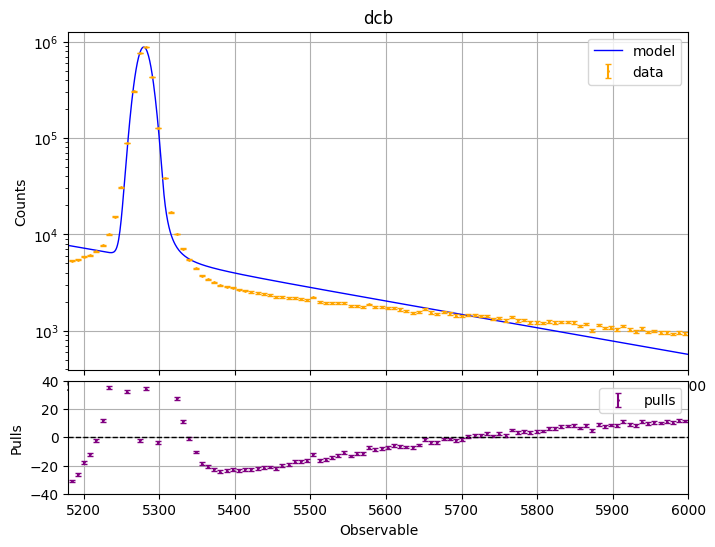

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_133, Composed_autoparam_134]] data=[<zfit.Data: Data obs=('mass',) shape=(2888926, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 1.2e-06 │      12198619.37 | -250478.9 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name            value  (rounded)    at limit
------------  ------------------  ----------
signal_yield         2.61701e+06       False
bck_yield                 271910       False
shift_mu                0.212947       False
scale_sigma              0.85367       False
lambda_bkg            -0.0031846       

In [93]:
#WITH double CB
real_mass = real_data['B_JpsiDTF_M']
real_mass_np = real_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(5180, 6000))
real_data_zfit = zfit.data.Data.from_numpy(array=real_mass_np, obs=mass_obs)

shift_mu = zfit.Parameter('shift_mu', 0.9, -12, 12)
scale_sigma = zfit.Parameter('scale_sigma', 1.1, 0.5, 1.9)

mu_dcb_base = zfit.Parameter('mu_dcb', 5279.4, 5279, 5290, floating=False)
sigma_dcb_base = zfit.Parameter('sigma_dcb_r', 11.4, 0.1, 15, floating=False)
alpha_dcb_l = zfit.Parameter('alpha_dcb_l', 23., 0.1, 30, floating=False)
n_dcb_l = zfit.Parameter('n_dcb_l', 11., 0.1, 20, floating=False)
alpha_dcb_r = zfit.Parameter('alpha_dcb_r', 2.6, 0.1, 30, floating=False)
n_dcb_r = zfit.Parameter('n_dcb_r', 2., 0.1, 20, floating=False)


mu_dcb = zfit.ComposedParameter('mu_g', lambda mu, shift: mu + shift, params=[mu_dcb_base, shift_mu])
sigma_dcb = zfit.ComposedParameter('sigma', lambda sigma, scale: sigma * scale, params=[sigma_dcb_base, scale_sigma])

# Define the PDF (dcb profile)
dcb = zfit.pdf.DoubleCB(obs=mass_obs, mu=mu_dcb, sigma=sigma_dcb, alphal=alpha_dcb_l, nl=n_dcb_l, alphar=alpha_dcb_r, nr=n_dcb_r)

lambda_bkg = zfit.Parameter('lambda_bkg', -0.0016, -0.01, 0.0)  # Negative for a falling exp
bkg_pdf = zfit.pdf.Exponential(obs=mass_obs, lambda_=lambda_bkg)

frac_dcb = zfit.Parameter('frac_dcb', 0.7, 0, 1, floating=False)
frac_bkg = zfit.Parameter('frac_bkg', 0.3, 0, 1)

signal_yield = zfit.Parameter('signal_yield', 0.8*len(real_mass_np), 0, len(real_mass_np))
bck_yield = zfit.Parameter('bck_yield', 0.2*len(real_mass_np), 0, len(real_mass_np))

signal_extended = dcb.create_extended(signal_yield)
bkg_ext = bkg_pdf.create_extended(bck_yield)
supermodel = zfit.pdf.SumPDF([signal_extended, bkg_ext])

nll = zfit.loss.ExtendedUnbinnedNLL(model=supermodel, data=real_data_zfit)

# Minimizer
minimizer_minuit = zfit.minimize.Minuit()
result_dcb = minimizer_minuit.minimize(loss=nll)

# Plot result
plot_model_with_pulls(supermodel, "dcb", real_data_zfit, 5180, 6000, nbins=100)

print(result_dcb)

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1550/664640697.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


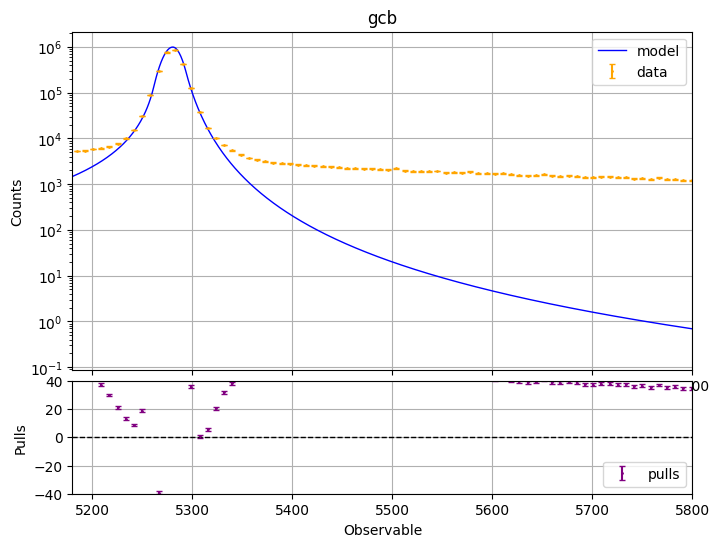

In [87]:
plot_model_with_pulls(gcb, "gcb", real_data_zfit, 5180, 5800, nbins=100)